<a target="_blank" href="https://colab.research.google.com/github/giordamaug/HELP/blob/main/HELPpy/notebooks/prediction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/giordamaug/HELP/blob/main/HELPpy/notebooks/prediction.ipynb">
  <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/>
</a>

### 1. Install HELP from GitHub
Skip this cell if you already have installed HELP.

In [ ]:
!pip install git+https://github.com/giordamaug/HELP.git

### 2. Download the input files
For a chosen tissue (here `Kidney`), download from GitHub the label file (here `Kidney_HELP.csv`, computed as in Example 1) and the attribute files (here BIO `Kidney_BIO.csv`, CCcfs `Kidney_CCcfs_1.csv`, ..., `Kidney_CCcfs_5.csv`, and N2V `Kidney_EmbN2V_128.csv`).  

Skip this step if you already have these input files locally.

In [ ]:
tissue='Kidney'
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_HELP.csv
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_BIO.csv
for i in range(5):
  !wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_CCcfs_{i}.csv
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_EmbN2V_128.csv

Observe that the CCcfs file has been subdivided into 5 separate files for storage limitations on GitHub. 

### 3. Load the input files and process the tissue attributes

+ The label file (`Kidney_HELP.csv`) can be loaded via `read_csv`; its three-class labels (`E`, `aE`, `sNE`) are converted to two-class labels (`E`, `NE`); 

+ The tissue gene attributes are loaded and assembled via `feature_assemble_df` using the downloaded datafiles BIO, CCcfs subdivided into 5 subfiles (`'nchunks': 5`) and embedding. We do not apply missing values fixing (`'fixna': False`), while we do apply data scaling (`'normalize': 'std'`) to the BIO and CCcfs attributes.  

In [1]:
%cd ../../data 
tissue='Brain'
import pandas as pd
from HELPpy.preprocess.loaders import feature_assemble_df
df_y = pd.read_csv(f"Brain_HELP.csv", index_col=0)
df_y = df_y.replace({'aE': 'NE', 'sNE': 'NE'})
print(df_y.value_counts(normalize=False))
features = [{'fname': f'{tissue}_BIO.csv', 'fixna' : False, 'normalize': 'std'},
            {'fname': f'{tissue}_CCcfs.csv', 'fixna' : False, 'normalize': 'std'},
            {'fname': f'{tissue}_EmbN2V_128.csv', 'fixna' : False, 'normalize': None}
            ]
df_X, df_y = feature_assemble_df(df_y, features=features, verbose=True)

/Users/maurizio/HELP/data
label
NE       16685
E         1246
dtype: int64
Majority NE 16685 minority E 1246
[Brain_BIO.csv] found 58547 Nan...
[Brain_BIO.csv] Normalization with std ...
[Brain_CCcfs.csv] found 6735590 Nan...
[Brain_CCcfs.csv] Normalization with std ...
[Brain_EmbN2V_128.csv] found 0 Nan...
[Brain_EmbN2V_128.csv] No normalization...
17244 labeled genes over a total of 17931
(17244, 3458) data input


### 4. Estimate the performance of EGs prediction 

Instantiate the prediction model described in the HELP paper (soft-voting ensemble `VotingSplitClassifier` of `n_voters=10` classifiers) and estimate its performance via 5-fold cross-validation (`k_fold_cv` with `n_splits=5`). Then, print the obtained average performances (`df_scores`)... 

In [12]:
from HELPpy.models.prediction import VotingEnsembleLGBM, k_fold_cv
#clf = VotingEnsembleLGBM(n_voters=10, learning_rate=0.5, boosting_type='gbdt', n_jobs=-1, random_state=42)
clf = VotingEnsembleLGBM(n_voters=17, learning_rate=0.03, n_estimators=140, boosting_type='gbdt', n_jobs=-1, random_state=42)
df_scores, scores, predictions = k_fold_cv(df_X, df_y, clf, n_splits=5, seed=0, show_progress=True, verbose=True)
df_scores

{'E': 0, 'NE': 1}
label
NE       16010
E         1234
dtype: int64
Classification with VotingEnsembleLGBM...


5-fold:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/maurizio/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maurizio/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maurizio/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maurizio/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a

,measure
ROC-AUC,0.9540±0.0064
Accuracy,0.8469±0.0065
BA,0.8813±0.0085
Sensitivity,0.9214±0.0137
Specificity,0.8412±0.0065
MCC,0.4799±0.0138
CM,"[[1137, 97], [2543, 13467]]"


... and those in each fold (`scores`)

In [11]:
import numpy as np
y_pred = predictions['prediction'].values.ravel()
y_prob = predictions['probabilities'].values.ravel()
y_true = predictions['label'].values.ravel()
from sklearn.metrics import *
from imblearn.metrics import specificity_score

print(pd.DataFrame({'ROC-AUC' : [roc_auc_score(y_true, 1-y_prob, average='weighted')],
              'Accuracy' : [accuracy_score(y_true, y_pred)],
              'Sensitivity' : [specificity_score(y_true, y_pred)],
              'Specificity' : [recall_score(y_true, y_pred)],
              'BA' : [balanced_accuracy_score(y_true, y_pred)],
              'MCC' : [matthews_corrcoef(y_true, y_pred)],
              'CM': [confusion_matrix(y_true, y_pred)]
              }).T.to_latex())

print(confusion_matrix(y_true, y_pred))

\begin{tabular}{ll}
\toprule
{} &                            0 \\
\midrule
ROC-AUC     &                     0.959359 \\
Accuracy    &                     0.861169 \\
Sensitivity &                     0.927877 \\
Specificity &                     0.856027 \\
BA          &                     0.891952 \\
MCC         &                     0.505082 \\
CM          &  [[1145, 89], [2305, 13705]] \\
\bottomrule
\end{tabular}

[[ 1145    89]
 [ 2305 13705]]


In [14]:
scores

,ROC-AUC,Accuracy,BA,Sensitivity,Specificity,MCC,CM
index,,,,,,,
0,0.954782,0.892143,0.882131,0.870445,0.893816,0.536297,"[[215, 32], [340, 2862]]"
1,0.950956,0.881705,0.880246,0.878543,0.881949,0.519001,"[[217, 30], [378, 2824]]"
2,0.966275,0.896202,0.904867,0.91498,0.894753,0.564935,"[[226, 21], [337, 2865]]"
3,0.952812,0.891273,0.891003,0.890688,0.891318,0.543655,"[[220, 27], [348, 2854]]"
4,0.954659,0.896462,0.886086,0.873984,0.898189,0.546476,"[[215, 31], [326, 2876]]"


Show labels, predictions and their probabilities (`predictions`) and save them in a csv file

In [5]:
predictions

,label,prediction,probabilities
gene,,,
A4GNT,1,1,0.007120
AAAS,1,0,0.943234
AASDH,1,1,0.070971
ABCA2,1,1,0.234408
ABCA3,1,1,0.016606
...,...,...,...
ZSWIM7,1,1,0.092465
ZSWIM8,1,1,0.293142
ZXDA,1,1,0.012429


In [6]:
import os
savepath = "../data4rev"
predictions.to_csv(os.path.join(savepath, f"csEGs_{tissue}_EvsNE.csv"), index=True)

### 5. Compute TPR for ucsEGs and csEGs

Read the result files for ucsEGs (`ucsEG_Kidney.txt`) and csEGs (`csEGs_Kidney_EvsNE.csv`) already computed for the tissue, compute the TPRs (tpr) and show their bar plot. 

ucsEG Brain TPR = 0.683 (28/41) ucsEG Brain TPR =  0.928 (1145/1234)


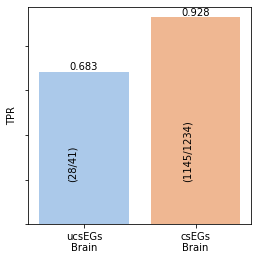

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
labels = []
data = []
tpr = []
genes = {}
#!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/ucsEG_{tissue}.txt
ucsEGs = pd.read_csv(f"ucsEG_{tissue}.txt", index_col=0, header=None).index.values
#!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/csEGs_{tissue}_EvsNE.csv
#predictions = pd.read_csv(f"csEGs_{tissue}_EvsNE.csv", index_col=0)
indices = np.intersect1d(ucsEGs, predictions.index.values)
preds = predictions.loc[indices]
num1 = len(preds[preds['label'] == preds['prediction']])
den1 = len(preds[preds['label'] == 0])
den2 = len(predictions[predictions['label'] == 0])
num2 = len(predictions[(predictions['label'] == 0) & (predictions['label'] == predictions['prediction'])])
labels += [f"ucsEGs\n{tissue}", f"csEGs\n{tissue}"]
data += [float(f"{num1 /den1:.3f}"), float(f"{num2 /den2:.3f}")]
tpr += [f"{num1}/{den1}", f"{num2}/{den2}"]
genes[f'ucsEGs_{tissue}_y'] = preds[preds['label'] == preds['prediction']].index.values
genes[f'ucsEGs_{tissue}_n'] = preds[preds['label'] != preds['prediction']].index.values
genes[f'csEGs_{tissue}_y'] = predictions[(predictions['label'] == 0) & (predictions['label'] == predictions['prediction'])].index.values
genes[f'csEGs_{tissue}_n'] = predictions[(predictions['label'] == 0) & (predictions['label'] != predictions['prediction'])].index.values
print(f"ucsEG {tissue} TPR = {num1 /den1:.3f} ({num1}/{den1}) ucsEG {tissue} TPR =  {num2/den2:.3f} ({num2}/{den2})")

f, ax = plt.subplots(figsize=(4, 4))
palette = sns.color_palette("pastel", n_colors=2)
sns.barplot(y = data, x = labels, ax=ax, hue= data, palette = palette, orient='v', legend=False)
ax.set_ylabel('TPR')
ax.set(yticklabels=[])
for i,l,t in zip(range(4),labels,tpr):
    ax.text(-0.15 + (i * 1.03), 0.2, f"({t})", rotation='vertical')
for i in ax.containers:
    ax.bar_label(i,)

This code can be used to produce Fig 5(B) of the HELP paper by executing an iteration cycle for both `kidney` and `lung` tissues.

At the end, we print the list of ucs_EGs for the tissue.

In [15]:
genes[f'ucsEGs_{tissue}_y']

array(['ACTB', 'CDK2', 'CDK6', 'CHMP7', 'CKS1B', 'DDX11', 'EMC3',
       'EXOSC1', 'FAM50A', 'FDXR', 'NCAPH2', 'NUP54', 'RBM48', 'RPL39',
       'SERBP1', 'SNRPB2', 'SRSF10', 'SSB', 'TAF1D', 'TIMM9', 'TOMM20',
       'URM1', 'USP10', 'VRK1'], dtype=object)